In [1]:
# Load modules

import xarray as xr
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import zarr
import gcsfs
import xesmf as xe
from scipy.interpolate import griddata
from xmip.preprocessing import rename_cmip6
from matplotlib import gridspec
import time

In [2]:
vert_ds = xr.open_dataarray('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/vert_ds.nc')
vert_ds.load()

<xarray.DataArray 'wap' (lat: 88, lon: 179)>
array([[ 9.05317347e-03,  5.35726221e-03,  3.90954921e-03, ...,
         1.37608778e-02,  1.27784014e-02,  1.16651980e-02],
       [ 1.62603296e-02,  1.84076093e-02,  1.68463495e-02, ...,
         2.34749150e-02,  2.32172329e-02,  2.24996507e-02],
       [ 1.72343142e-02,  1.73817184e-02,  1.67526975e-02, ...,
         1.50780585e-02,  1.46754114e-02,  1.46230198e-02],
       ...,
       [-2.22924957e-03, -1.80104235e-03, -1.62051118e-03, ...,
        -1.75005000e-03, -2.10483326e-03, -2.04990618e-03],
       [-6.93217677e-04, -1.27934688e-03, -1.30213355e-03, ...,
        -7.43095938e-04, -8.93206510e-04, -9.83634265e-04],
       [ 4.50923544e-04, -8.85086847e-05,  6.49775393e-05, ...,
        -5.63950336e-04, -4.56162205e-04, -3.77876189e-04]], dtype=float32)
Coordinates:
    plev     float64 5e+04
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [ ]:
# Head to google catalog to get some vertical motion data

# Read in data catalog

df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

# SST - piControl

In [16]:
# Find SST

df_sst_control = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'ts' & experiment_id == 'piControl'")
df_sst_control = df_sst_control.drop_duplicates('source_id').head(23)
df_sst_control = df_sst_control.drop(index=44330)
df_sst_control = df_sst_control.drop(index=55630)
df_sst_control = df_sst_control.drop(index=67594)
df_sst_control = df_sst_control.drop(index=67702)
#df_sst_control = df_sst_control.drop(index=246458)
#df_sst_control = df_sst_control.drop(index=253865)
#df_sst_control = df_sst_control.drop(index=375351)
#df_sst_control = df_sst_control.drop(index=385525)
#df_sst_control = df_sst_control.drop(index=416429)
df_sst_control = df_sst_control.drop(index=75733)
df_sst_control = df_sst_control.drop(index=206179)
df_sst_control = df_sst_control.drop(index=209012)
df_sst_control = df_sst_control.drop(index=217984)
df_sst_control = df_sst_control.drop(index=236032)
df_sst_control = df_sst_control.drop(index=237883)
df_sst_control = df_sst_control.drop(index=66921)
df_sst_control

activity_id     institution_id        source_id experiment_id  \
9418          CMIP          NOAA-GFDL         GFDL-CM4     piControl   
18366         CMIP          NOAA-GFDL        GFDL-ESM4     piControl   
31900         CMIP       CNRM-CERFACS       CNRM-CM6-1     piControl   
32184         CMIP          NASA-GISS      GISS-E2-1-G     piControl   
40419         CMIP                BCC      BCC-CSM2-MR     piControl   
42780         CMIP       CNRM-CERFACS      CNRM-ESM2-1     piControl   
44600         CMIP                BCC         BCC-ESM1     piControl   
87889         CMIP              CCCma    CanESM5-CanOE     piControl   
90064         CMIP              CCCma          CanESM5     piControl   
211884        CMIP  HAMMOZ-Consortium  MPI-ESM-1-2-HAM     piControl   
213497        CMIP               MOHC  HadGEM3-GC31-LL     piControl   
243312        CMIP       E3SM-Project         E3SM-1-0     piControl   

       member_id table_id variable_id grid_label  \
9418    r1i1p1f1     Amon          ts        gr1   
18366   r1i1p1f1     Amon          ts        gr1   
31900   r1i1p1f2     Amon          ts         gr   
32184   r1i1p1f1     Amon          ts         gn   
40419   r1i1p1f1     Amon          ts         gn   
42780   r1i1p1f2     Amon          ts         gr   
44600   r1i1p1f1     Amon          ts         gn   
87889   r1i1p2f1     Amon          ts         gn   
90064   r1i1p1f1     Amon          ts         gn   
211884  r1i1p1f1     Amon          ts         gn   
213497  r1i1p1f1     Amon          ts         gn   
243312  r1i1p1f1     Amon          ts         gr   

                                                   zstore  dcpp_init_year  \
9418    gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...             NaN   
18366   gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/piCo...             NaN   
31900   gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...             NaN   
32184   gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/pi...             NaN   
40419   gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/piContro...             NaN   
42780   gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...             NaN   
44600   gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/piControl/r...             NaN   
87889   gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/piCo...             NaN   
90064   gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/piControl/...             NaN   
211884  gs://cmip6/CMIP6/CMIP/HAMMOZ-Consortium/MPI-ES...             NaN   
213497  gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/piC...             NaN   
243312  gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/pi...             NaN   

         version  
9418    20180701  
18366   20180701  
31900   20180814  
32184   20180824  
40419   20181016  
42780   20181115  
44600   20181214  
87889   20190429  
90064   20190429  
211884  20190627  
213497  20190628  
243312  20190719

#### Load MIROC6

In [17]:
df_sst_miroc6 = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'ts' & experiment_id == 'piControl' & source_id == 'MIROC6'")
df_sst_miroc6

activity_id institution_id source_id experiment_id member_id table_id  \
44330        CMIP          MIROC    MIROC6     piControl  r1i1p1f1     Amon   

      variable_id grid_label  \
44330          ts         gn   

                                                  zstore  dcpp_init_year  \
44330  gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/piControl/r...             NaN   

        version  
44330  20181212

#### Add FGOALS-g3

In [8]:
df_sst_fgoals = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'ts' & experiment_id == 'piControl' & source_id == 'FGOALS-g3'")
df_sst_fgoals

activity_id institution_id  source_id experiment_id member_id table_id  \
254979        CMIP            CAS  FGOALS-g3     piControl  r1i1p1f1     Amon   

       variable_id grid_label  \
254979          ts         gn   

                                                   zstore  dcpp_init_year  \
254979  gs://cmip6/CMIP6/CMIP/CAS/FGOALS-g3/piControl/...             NaN   

         version  
254979  20190818

#### Add IPSL dataset

In [18]:
df_sst_ipsl = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'ts' & experiment_id == 'piControl' & source_id == 'IPSL-CM6A-LR' & member_id=='r1i1p1f1'")
df_sst_ipsl

activity_id institution_id     source_id experiment_id member_id  \
429109        CMIP           IPSL  IPSL-CM6A-LR     piControl  r1i1p1f1   

       table_id variable_id grid_label  \
429109     Amon          ts         gr   

                                                   zstore  dcpp_init_year  \
429109  gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piCont...             NaN   

         version  
429109  20200326

In [19]:
df_sst_control = df_sst_control.append(df_sst_miroc6)
df_sst_control = df_sst_control.append(df_sst_fgoals)
df_sst_control = df_sst_control.append(df_sst_ipsl)
df_sst_control

/tmp/ipykernel_4987/2793282092.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sst_control = df_sst_control.append(df_sst_miroc6)
/tmp/ipykernel_4987/2793282092.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sst_control = df_sst_control.append(df_sst_fgoals)
/tmp/ipykernel_4987/2793282092.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sst_control = df_sst_control.append(df_sst_ipsl)


activity_id     institution_id        source_id experiment_id  \
9418          CMIP          NOAA-GFDL         GFDL-CM4     piControl   
18366         CMIP          NOAA-GFDL        GFDL-ESM4     piControl   
31900         CMIP       CNRM-CERFACS       CNRM-CM6-1     piControl   
32184         CMIP          NASA-GISS      GISS-E2-1-G     piControl   
40419         CMIP                BCC      BCC-CSM2-MR     piControl   
42780         CMIP       CNRM-CERFACS      CNRM-ESM2-1     piControl   
44600         CMIP                BCC         BCC-ESM1     piControl   
87889         CMIP              CCCma    CanESM5-CanOE     piControl   
90064         CMIP              CCCma          CanESM5     piControl   
211884        CMIP  HAMMOZ-Consortium  MPI-ESM-1-2-HAM     piControl   
213497        CMIP               MOHC  HadGEM3-GC31-LL     piControl   
243312        CMIP       E3SM-Project         E3SM-1-0     piControl   
44330         CMIP              MIROC           MIROC6     piControl   
254979        CMIP                CAS        FGOALS-g3     piControl   
429109        CMIP               IPSL     IPSL-CM6A-LR     piControl   

       member_id table_id variable_id grid_label  \
9418    r1i1p1f1     Amon          ts        gr1   
18366   r1i1p1f1     Amon          ts        gr1   
31900   r1i1p1f2     Amon          ts         gr   
32184   r1i1p1f1     Amon          ts         gn   
40419   r1i1p1f1     Amon          ts         gn   
42780   r1i1p1f2     Amon          ts         gr   
44600   r1i1p1f1     Amon          ts         gn   
87889   r1i1p2f1     Amon          ts         gn   
90064   r1i1p1f1     Amon          ts         gn   
211884  r1i1p1f1     Amon          ts         gn   
213497  r1i1p1f1     Amon          ts         gn   
243312  r1i1p1f1     Amon          ts         gr   
44330   r1i1p1f1     Amon          ts         gn   
254979  r1i1p1f1     Amon          ts         gn   
429109  r1i1p1f1     Amon          ts         gr   

                                                   zstore  dcpp_init_year  \
9418    gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...             NaN   
18366   gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/piCo...             NaN   
31900   gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...             NaN   
32184   gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/pi...             NaN   
40419   gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/piContro...             NaN   
42780   gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...             NaN   
44600   gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/piControl/r...             NaN   
87889   gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/piCo...             NaN   
90064   gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/piControl/...             NaN   
211884  gs://cmip6/CMIP6/CMIP/HAMMOZ-Consortium/MPI-ES...             NaN   
213497  gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/piC...             NaN   
243312  gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/pi...             NaN   
44330   gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/piControl/r...             NaN   
254979  gs://cmip6/CMIP6/CMIP/CAS/FGOALS-g3/piControl/...             NaN   
429109  gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piCont...             NaN   

         version  
9418    20180701  
18366   20180701  
31900   20180814  
32184   20180824  
40419   20181016  
42780   20181115  
44600   20181214  
87889   20190429  
90064   20190429  
211884  20190627  
213497  20190628  
243312  20190719  
44330   20181212  
254979  20190818  
429109  20200326

In [25]:
#this only needs to be created once
# From Ryan Abernathy's tutorial - Way 2
gcs = gcsfs.GCSFileSystem(token='anon')
fs = gcsfs.GCSFileSystem(token='anon', access='read_only')

# Regridding
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

#time index to assign model times to
new_time_index=pd.date_range(start='1851-01-01',freq='M',periods=3000) #250 years
new_time_index
    
dset_list_sst = []
for zstore in df_sst_control.zstore.unique():
    # make a nice concise name from the zstore value
    name = zstore.split('gs://cmip6/CMIP6/')[1].replace('/','.')[:-1]
    name = zstore.split('gs://cmip6/CMIP6/CMIP/')[1].replace('/','.')[:-1]
    name_list = name.split('.')
    name = name_list[1]
    print(name)
    ds = xr.open_zarr(fs.get_mapper(zstore),consolidated=True)
    ds_sel = ds.isel(time=slice(300,3300))
    ds_surface_interp = ds_sel.assign(time=new_time_index).interp(lat=new_lats,lon=new_lons)
    ds_sst = ds_surface_interp.ts
    ds_sst['name'] = name # Creating a new dimension for each ensemble member
    dset_list_sst.append(ds_sst)

GFDL-CM4
GFDL-ESM4
CNRM-CM6-1


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


GISS-E2-1-G
BCC-CSM2-MR
CNRM-ESM2-1
BCC-ESM1
CanESM5-CanOE
CanESM5
MPI-ESM-1-2-HAM


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dty

HadGEM3-GC31-LL
E3SM-1-0
MIROC6


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use

FGOALS-g3
IPSL-CM6A-LR


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


In [26]:
SST_control = xr.concat(dset_list_sst, dim='name', coords='minimal', compat='override')
SST_control.load()

<xarray.DataArray 'ts' (name: 15, time: 3000, lat: 88, lon: 179)>
array([[[[243.18496246, 243.0430336 , 242.90864563, ..., 243.75744705,
          243.6136322 , 243.47025681],
         [243.91621094, 243.58426437, 243.37599564, ..., 245.18914566,
          244.86694336, 244.54597549],
         [245.59149551, 245.1326683 , 244.65911102, ..., 247.68568878,
          247.14878464, 246.61694489],
         ...,
         [239.55025787, 239.92131195, 240.25101852, ..., 237.72741852,
          237.87510681, 238.06498566],
         [238.32813339, 238.6320961 , 238.78931427, ..., 237.56899948,
          237.70903015, 237.84785614],
         [236.66961594, 236.70400772, 236.74081421, ..., 236.53036346,
          236.56542206, 236.60032578]],

        [[231.3177597 , 231.15438766, 231.01077652, ..., 231.97694626,
          231.81131363, 231.64621048],
         [232.09978867, 231.65678024, 231.46744919, ..., 233.87158051,
          233.43950653, 233.00966873],
         [234.51739807, 234.01972885, 233.50682068, ..., 237.02090225,
          236.37061691, 235.73139725],
...
         [252.6314019 , 253.00705589, 253.27285173, ..., 250.59691569,
          251.33007984, 251.73059956],
         [250.57741261, 250.86533582, 251.07462841, ..., 249.44685013,
          249.71823049, 249.99883515],
         [249.48820074, 249.57583261, 249.61054581, ..., 249.09102365,
          249.2286624 , 249.33934194]],

        [[245.89039754, 245.79137869, 245.69797414, ..., 246.28718255,
          246.18609571, 246.08100414],
         [246.221572  , 246.11203082, 246.03149157, ..., 246.92299288,
          246.67959114, 246.49861298],
         [247.77117087, 247.41665991, 247.12117474, ..., 249.08780638,
          248.75362614, 248.43839637],
         ...,
         [247.44068585, 247.76085688, 248.02600625, ..., 245.28867583,
          245.93020479, 246.44387522],
         [245.94969518, 246.23730513, 246.43921414, ..., 244.95586261,
          245.21822464, 245.41741683],
         [245.20291891, 245.41547107, 245.56769846, ..., 244.54256509,
          244.69713293, 244.88479369]]]])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 2100-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) <U15 'GFDL-CM4' 'GFDL-ESM4' ... 'FGOALS-g3' 'IPSL-CM6A-LR'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Surface Temperature
    original_name:  ts
    standard_name:  surface_temperature
    units:          K

In [61]:
SST_control.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/250yeardatasets/CMIP_ts_piControl_2x2_250yr.nc')

## Mean surface temperature

Text(0.5, 0.99, 'Mean TS')

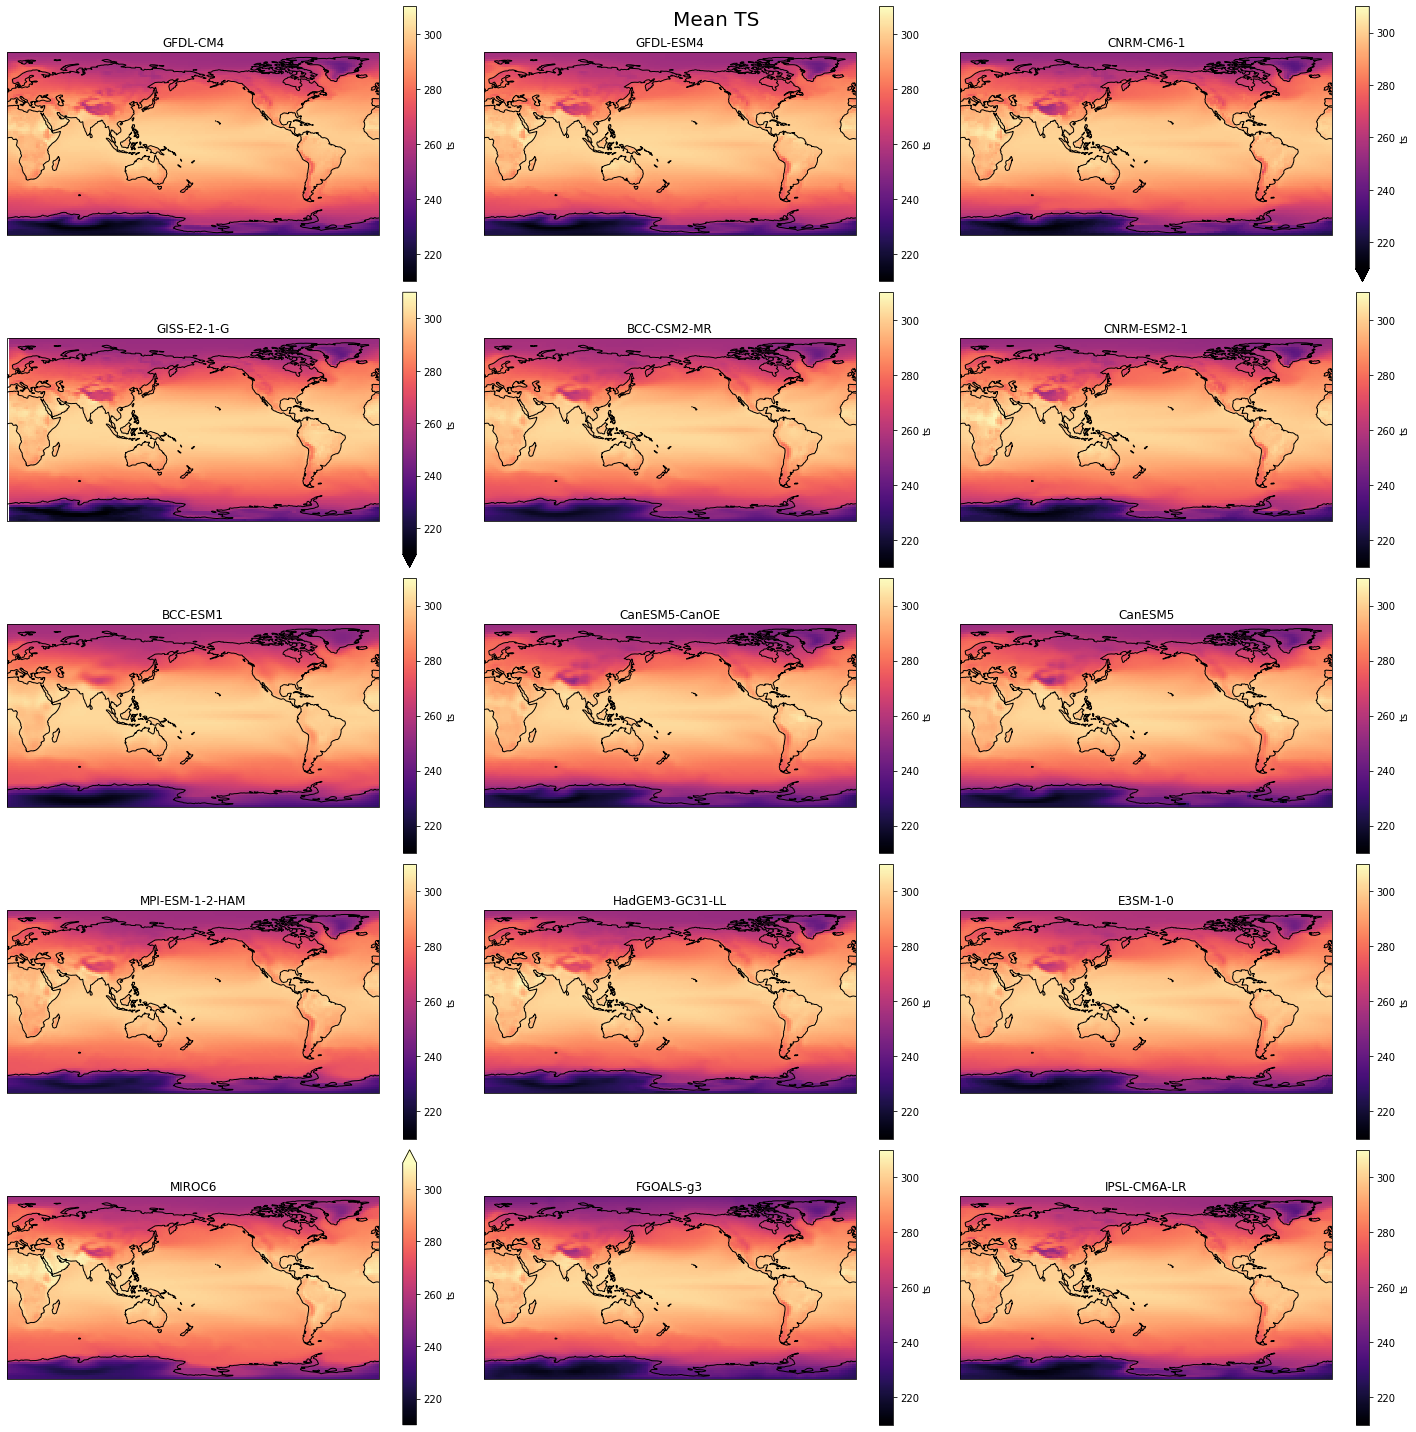

In [57]:
fig = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.1)

i = 1

for model in SST_control['name'].values:
    ax = fig.add_subplot(5,3,i, projection=ccrs.PlateCarree(central_longitude=180))
    SST_control.sel(name=model).mean('time').plot(ax=ax, transform=ccrs.PlateCarree(), vmin=210, vmax=310, cmap='magma')
    ax.coastlines(color='black', linewidth=1)
    plt.title(model)
    i += 1
plt.tight_layout()
plt.suptitle('Mean TS', fontsize=20, y=0.99)

## Surface temperature interdecadal variability

Text(0.5, 0.99, 'TS Interdecadal Variability')

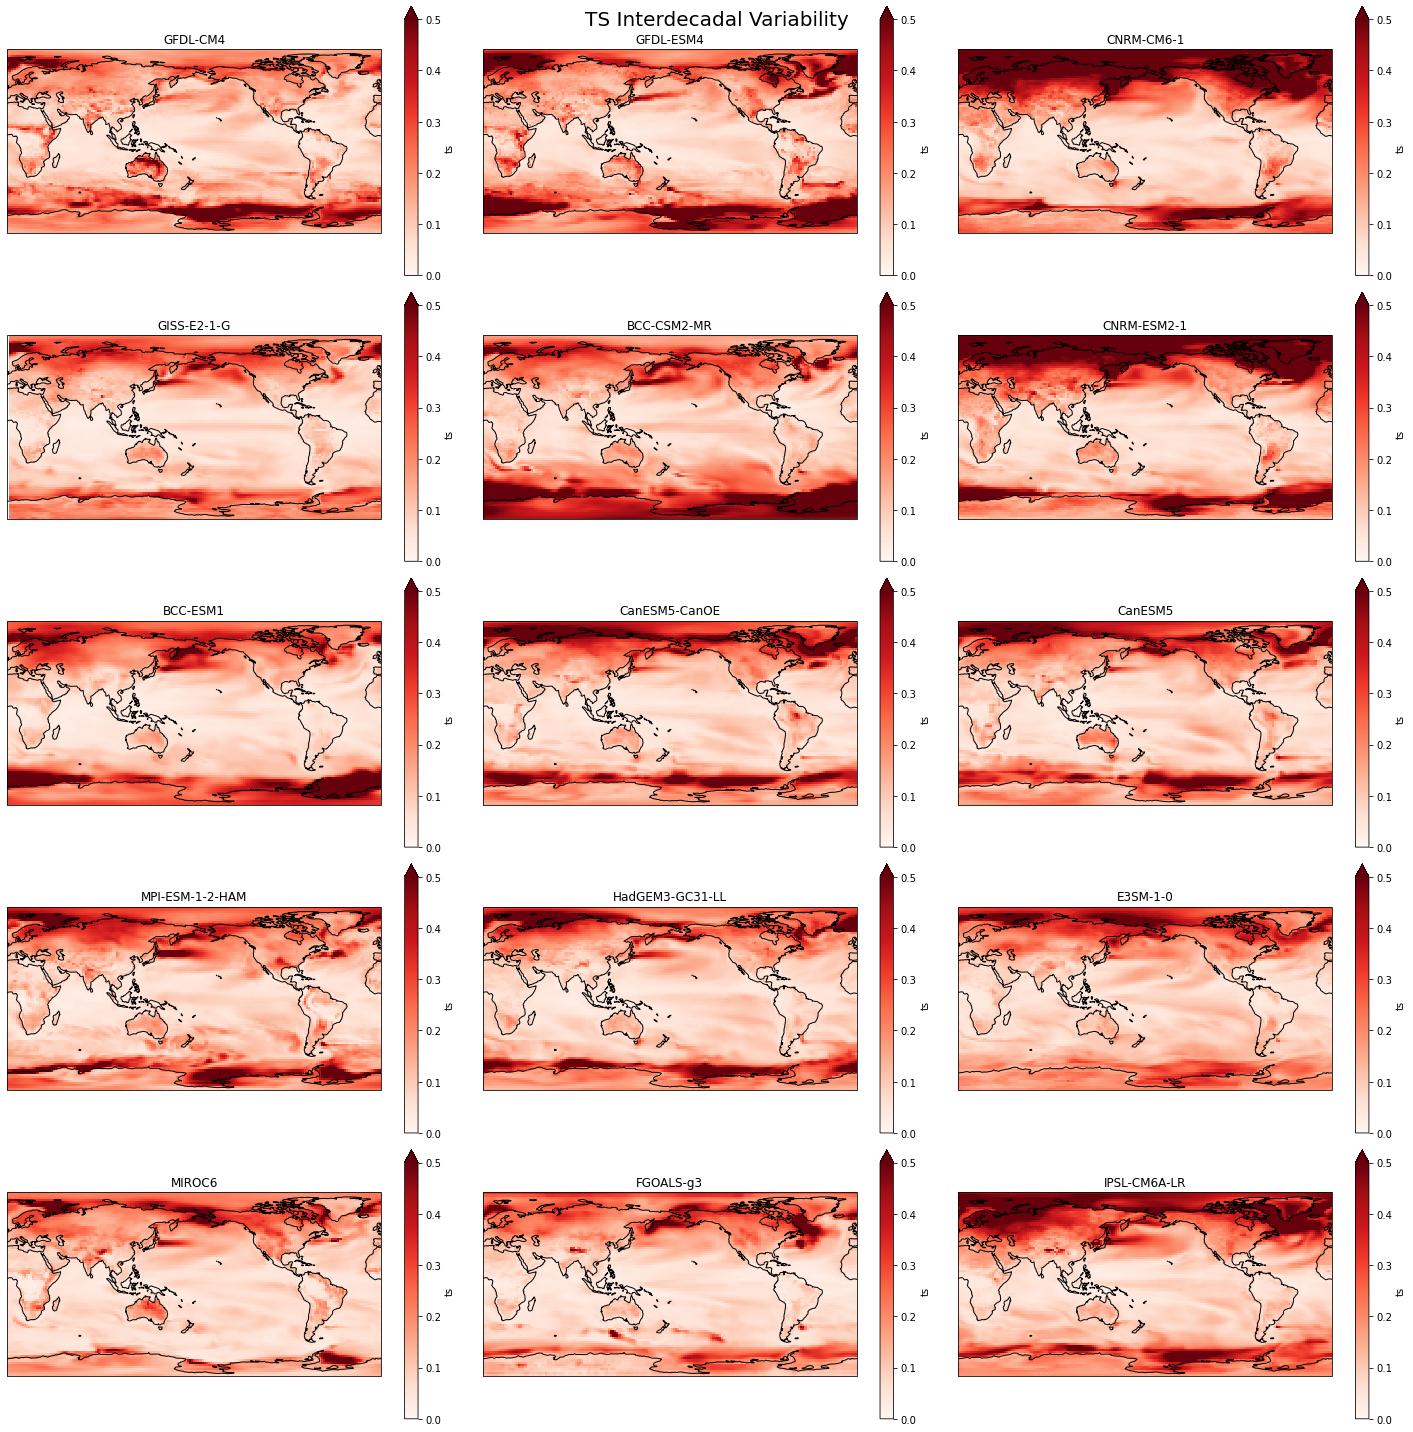

In [58]:
fig = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.1)

i = 1

for model in SST_control['name'].values:
    ax = fig.add_subplot(5,3,i, projection=ccrs.PlateCarree(central_longitude=180))
    rolling = SST_control.sel(name=model).rolling(time=300, center=True).mean('time')
    rolling.std('time').plot(ax=ax, transform=ccrs.PlateCarree(), vmin=0, vmax=0.5, cmap='Reds')
    ax.coastlines(color='black', linewidth=1)
    plt.title(model)
    i += 1
plt.tight_layout()
plt.suptitle('TS Interdecadal Variability', fontsize=20, y=0.99)

## Ensemble Mean Surface Temperature Interdecadal Variability

In [44]:
SST_rolling = SST_control.rolling(time=300, center=True).mean('time')
SST_stand = SST_rolling.std('time')
SST_var = SST_stand.mean('name')

Text(0.5, 1.0, '25 year TS interdecadal variability (N=15)')

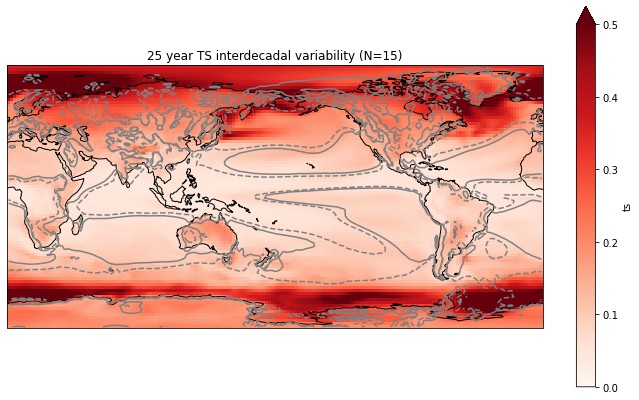

In [60]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
SST_var.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=0, vmax=0.5, cmap='Reds')
ax.coastlines(color='black', linewidth=1)
vert_ds.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title('25 year TS interdecadal variability (N=15)')

# MLOTST Control

In [90]:
df_mlotst_control = df.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'mlotst' & experiment_id == 'piControl'")
df_mlotst_control = df_mlotst_control.drop_duplicates('source_id').head(14)
df_mlotst_control = df_mlotst_control.drop(index=45755)
df_mlotst_control = df_mlotst_control.drop(index=66986)
df_mlotst_control = df_mlotst_control.drop(index=67207)
df_mlotst_control = df_mlotst_control.drop(index=67683)
df_mlotst_control = df_mlotst_control.drop(index=215642)
df_mlotst_control

activity_id institution_id      source_id experiment_id member_id  \
9212         CMIP      NOAA-GFDL       GFDL-CM4     piControl  r1i1p1f1   
16244        CMIP      NOAA-GFDL      GFDL-ESM4     piControl  r1i1p1f1   
31863        CMIP   CNRM-CERFACS     CNRM-CM6-1     piControl  r1i1p1f2   
32207        CMIP      NASA-GISS    GISS-E2-1-G     piControl  r1i1p1f1   
40214        CMIP            BCC    BCC-CSM2-MR     piControl  r1i1p1f1   
42727        CMIP   CNRM-CERFACS    CNRM-ESM2-1     piControl  r1i1p1f2   
45366        CMIP            BCC       BCC-ESM1     piControl  r1i1p1f1   
87841        CMIP          CCCma  CanESM5-CanOE     piControl  r1i1p2f1   
89859        CMIP          CCCma        CanESM5     piControl  r1i1p1f1   

      table_id variable_id grid_label  \
9212      Omon      mlotst         gr   
16244     Omon      mlotst         gr   
31863     Omon      mlotst         gn   
32207     Omon      mlotst         gn   
40214     Omon      mlotst         gn   
42727     Omon      mlotst         gn   
45366     Omon      mlotst         gn   
87841     Omon      mlotst         gn   
89859     Omon      mlotst         gn   

                                                  zstore  dcpp_init_year  \
9212   gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...             NaN   
16244  gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/piCo...             NaN   
31863  gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...             NaN   
32207  gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/pi...             NaN   
40214  gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/piContro...             NaN   
42727  gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...             NaN   
45366  gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/piControl/r...             NaN   
87841  gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/piCo...             NaN   
89859  gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/piControl/...             NaN   

        version  
9212   20180701  
16244  20180701  
31863  20180814  
32207  20180824  
40214  20181015  
42727  20181115  
45366  20181218  
87841  20190429  
89859  20190429

### Load HadGEM3-GC31-LL

In [91]:
df_hml_HadGEM3 = df.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'mlotst' & experiment_id == 'piControl' & source_id == 'HadGEM3-GC31-LL'").head(1)
df_hml_HadGEM3

activity_id institution_id        source_id experiment_id member_id  \
523689        CMIP           MOHC  HadGEM3-GC31-LL     piControl  r1i1p1f1   

       table_id variable_id grid_label  \
523689     Omon      mlotst         gn   

                                                   zstore  dcpp_init_year  \
523689  gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/piC...             NaN   

         version  
523689  20211103

### Load MPI-ESM-1-2-HAM

In [92]:
df_hml_MPIESM = df.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'mlotst' & experiment_id == 'piControl' & source_id == 'MPI-ESM-1-2-HAM'").head(1)
df_hml_MPIESM

activity_id     institution_id        source_id experiment_id  \
407439        CMIP  HAMMOZ-Consortium  MPI-ESM-1-2-HAM     piControl   

       member_id table_id variable_id grid_label  \
407439  r1i1p1f1     Omon      mlotst         gn   

                                                   zstore  dcpp_init_year  \
407439  gs://cmip6/CMIP6/CMIP/HAMMOZ-Consortium/MPI-ES...             NaN   

         version  
407439  20200120

### Load IPSL-CM6A-LR

In [93]:
df_hml_IPSL = df.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'mlotst' & experiment_id == 'piControl' & source_id == 'IPSL-CM6A-LR' & member_id == 'r1i1p1f1'").head(1)
df_hml_IPSL

activity_id institution_id     source_id experiment_id member_id  \
429180        CMIP           IPSL  IPSL-CM6A-LR     piControl  r1i1p1f1   

       table_id variable_id grid_label  \
429180     Omon      mlotst         gn   

                                                   zstore  dcpp_init_year  \
429180  gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piCont...             NaN   

         version  
429180  20200326

### Load E3SM-1-0

In [94]:
df_hml_E3SM = df.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'mlotst' & experiment_id == 'piControl' & source_id == 'E3SM-1-0'").head(1)
df_hml_E3SM

activity_id institution_id source_id experiment_id member_id table_id  \
409985        CMIP   E3SM-Project  E3SM-1-0     piControl  r1i1p1f1     Omon   

       variable_id grid_label  \
409985      mlotst         gr   

                                                   zstore  dcpp_init_year  \
409985  gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/pi...             NaN   

         version  
409985  20200129

### Load MIROC6

In [95]:
df_hml_MIROC = df.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'mlotst' & experiment_id == 'piControl' & source_id == 'MIROC6'").head(1)
df_hml_MIROC

activity_id institution_id source_id experiment_id member_id table_id  \
514126        CMIP          MIROC    MIROC6     piControl  r1i1p1f1     Omon   

       variable_id grid_label  \
514126      mlotst         gn   

                                                   zstore  dcpp_init_year  \
514126  gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/piControl/r...             NaN   

         version  
514126  20210129

### Load FGOALS-g3

In [96]:
df_hml_FGOALS = df.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'mlotst' & experiment_id == 'piControl' & source_id == 'FGOALS-g3'").head(1)
df_hml_FGOALS

activity_id institution_id  source_id experiment_id member_id table_id  \
391454        CMIP            CAS  FGOALS-g3     piControl  r1i1p1f1     Omon   

       variable_id grid_label  \
391454      mlotst         gn   

                                                   zstore  dcpp_init_year  \
391454  gs://cmip6/CMIP6/CMIP/CAS/FGOALS-g3/piControl/...             NaN   

         version  
391454  20191125

In [98]:
df_mlotst_control = df_mlotst_control.append(df_hml_HadGEM3)
df_mlotst_control = df_mlotst_control.append(df_hml_MPIESM)
df_mlotst_control = df_mlotst_control.append(df_hml_IPSL)
df_mlotst_control = df_mlotst_control.append(df_hml_E3SM)
df_mlotst_control = df_mlotst_control.append(df_hml_MIROC)
df_mlotst_control = df_mlotst_control.append(df_hml_FGOALS)
df_mlotst_control

/tmp/ipykernel_117067/2213031069.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mlotst_control = df_mlotst_control.append(df_hml_HadGEM3)
/tmp/ipykernel_117067/2213031069.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mlotst_control = df_mlotst_control.append(df_hml_MPIESM)
/tmp/ipykernel_117067/2213031069.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mlotst_control = df_mlotst_control.append(df_hml_IPSL)
/tmp/ipykernel_117067/2213031069.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mlotst_control = df_mlotst_control.append(df_hml_E3SM)
/tmp/ipykernel_117067/2213031069.py:5: FutureWarning: The frame.app

activity_id     institution_id        source_id experiment_id  \
9212          CMIP          NOAA-GFDL         GFDL-CM4     piControl   
16244         CMIP          NOAA-GFDL        GFDL-ESM4     piControl   
31863         CMIP       CNRM-CERFACS       CNRM-CM6-1     piControl   
32207         CMIP          NASA-GISS      GISS-E2-1-G     piControl   
40214         CMIP                BCC      BCC-CSM2-MR     piControl   
42727         CMIP       CNRM-CERFACS      CNRM-ESM2-1     piControl   
45366         CMIP                BCC         BCC-ESM1     piControl   
87841         CMIP              CCCma    CanESM5-CanOE     piControl   
89859         CMIP              CCCma          CanESM5     piControl   
523689        CMIP               MOHC  HadGEM3-GC31-LL     piControl   
407439        CMIP  HAMMOZ-Consortium  MPI-ESM-1-2-HAM     piControl   
429180        CMIP               IPSL     IPSL-CM6A-LR     piControl   
409985        CMIP       E3SM-Project         E3SM-1-0     piControl   
514126        CMIP              MIROC           MIROC6     piControl   
391454        CMIP                CAS        FGOALS-g3     piControl   

       member_id table_id variable_id grid_label  \
9212    r1i1p1f1     Omon      mlotst         gr   
16244   r1i1p1f1     Omon      mlotst         gr   
31863   r1i1p1f2     Omon      mlotst         gn   
32207   r1i1p1f1     Omon      mlotst         gn   
40214   r1i1p1f1     Omon      mlotst         gn   
42727   r1i1p1f2     Omon      mlotst         gn   
45366   r1i1p1f1     Omon      mlotst         gn   
87841   r1i1p2f1     Omon      mlotst         gn   
89859   r1i1p1f1     Omon      mlotst         gn   
523689  r1i1p1f1     Omon      mlotst         gn   
407439  r1i1p1f1     Omon      mlotst         gn   
429180  r1i1p1f1     Omon      mlotst         gn   
409985  r1i1p1f1     Omon      mlotst         gr   
514126  r1i1p1f1     Omon      mlotst         gn   
391454  r1i1p1f1     Omon      mlotst         gn   

                                                   zstore  dcpp_init_year  \
9212    gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...             NaN   
16244   gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/piCo...             NaN   
31863   gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...             NaN   
32207   gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/pi...             NaN   
40214   gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/piContro...             NaN   
42727   gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...             NaN   
45366   gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/piControl/r...             NaN   
87841   gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/piCo...             NaN   
89859   gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/piControl/...             NaN   
523689  gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/piC...             NaN   
407439  gs://cmip6/CMIP6/CMIP/HAMMOZ-Consortium/MPI-ES...             NaN   
429180  gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piCont...             NaN   
409985  gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/pi...             NaN   
514126  gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/piControl/r...             NaN   
391454  gs://cmip6/CMIP6/CMIP/CAS/FGOALS-g3/piControl/...             NaN   

         version  
9212    20180701  
16244   20180701  
31863   20180814  
32207   20180824  
40214   20181015  
42727   20181115  
45366   20181218  
87841   20190429  
89859   20190429  
523689  20211103  
407439  20200120  
429180  20200326  
409985  20200129  
514126  20210129  
391454  20191125

In [111]:
mlotst_list = []
for model in df_mlotst_control.zstore.unique():
    mlotst_model = mlotst_load_ufunc(model)
    mlotst_list.append(mlotst_model)

GFDL-CM4
GFDL-CM4 processed
<xarray.DataArray 'mlotst' (time: 3000, lat: 88, lon: 179)>
dask.array<dask_aware_interpnd, shape=(3000, 88, 179), dtype=float32, chunksize=(670, 88, 179), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 2100-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
    name     <U8 'GFDL-CM4'
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    interp_method:  conserve_order1
    long_name:      Ocean Mixed Layer Thickness Defined by Sigma T
    original_name:  mlotst
    standard_name:  ocean_mixed_layer_thickness_defined_by_sigma_t
    units:          m
GFDL-ESM4
GFDL-ESM4 processed
<xarray.DataArray 'mlotst' (time: 3000, lat: 88, lon: 179)>
dask.array<dask_aware_interpnd

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dty

CNRM-CM6-1 processed
<xarray.DataArray (time: 3000, lat: 88, lon: 179)>
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [35.86421967, 34.95941925, 34.82583237, ..., 36.27495575,
         37.32522583, 37.14268494],
        [31.37464714, 30.99547958, 30.88829231, ..., 33.08013153,
         32.4210701 , 32.03507996],
        [30.77065277, 30.77463722, 30.77843666, ..., 30.75943375,
         30.76066017, 30.76291847]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.      

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dty

CNRM-ESM2-1 processed
<xarray.DataArray (time: 3000, lat: 88, lon: 179)>
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [29.98419571, 31.42145348, 31.59262848, ..., 27.93704796,
         27.83479881, 28.07898521],
        [31.71488571, 31.84480286, 32.02974319, ..., 29.56868362,
         30.17036438, 30.82302475],
        [35.67639923, 36.17217255, 36.66423035, ..., 34.15082169,
         34.38127899, 34.7228241 ]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.     

/tmp/ipykernel_117067/4290521880.py:61: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  zout = xr.apply_ufunc(interp_griddata, xin, yin, zin, xm, ym,


CanESM5-CanOE processed
<xarray.DataArray (time: 3000, lat: 88, lon: 179)>
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [62.49842453, 63.63875198, 59.1202774 , ..., 60.08398819,
         57.74235153, 59.15263367],
        [64.43428802, 65.24723816, 65.62102509, ..., 55.30196381,
         56.87231445, 59.29928589],
        [66.13974762, 66.17184448, 66.19309235, ..., 65.85865021,
         65.98265076, 66.06497192]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.   

/tmp/ipykernel_117067/4290521880.py:61: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  zout = xr.apply_ufunc(interp_griddata, xin, yin, zin, xm, ym,


CanESM5 processed
<xarray.DataArray (time: 3000, lat: 88, lon: 179)>
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [48.57738113, 56.96133423, 72.45801544, ..., 60.79089737,
         49.94495392, 46.42199707],
        [47.92631912, 53.68194199, 60.33453751, ..., 48.13340759,
         45.07737732, 45.00929642],
        [75.69916534, 77.77854156, 79.31349945, ..., 63.91765976,
         67.54042816, 70.78962708]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]

/tmp/ipykernel_117067/4290521880.py:61: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  zout = xr.apply_ufunc(interp_griddata, xin, yin, zin, xm, ym,


HadGEM3-GC31-LL processed
<xarray.DataArray (time: 3000, lat: 88, lon: 179)>
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [30.71750832, 29.64086151, 28.25364876, ..., 37.24291229,
         35.04535294, 33.25634766],
        [31.68507385, 31.73269653, 31.76385498, ..., 31.45937347,
         31.4696579 , 31.54091835],
        [34.02612305, 34.09165192, 34.13754654, ..., 33.83340836,
         33.86871338, 33.91246033]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [        nan,         nan,         nan, ...,         nan,
                 nan,     

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dty

MPI-ESM-1-2-HAM processed
<xarray.DataArray (time: 3000, lat: 88, lon: 179)>
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [39.63874435, 36.66211319, 34.92984772, ..., 40.33957291,
         37.88332748, 37.25049973],
        [36.01321793, 34.47758102, 32.61141205, ..., 34.647686  ,
         37.64544296, 37.38264847],
        [24.92670822, 24.50700188, 24.4896946 , ..., 28.82389641,
         28.28965378, 27.01908684]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0. 

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/tmp/ipykernel_117067/4290521880.py:61: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  zout = xr.apply_ufunc(interp_griddata, xin, yin, zin, xm, ym,


IPSL-CM6A-LR processed
<xarray.DataArray (time: 3000, lat: 88, lon: 179)>
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [20.70384216, 22.95493126, 23.76465416, ..., 15.15270901,
         15.01055527, 16.40398788],
        [16.11410522, 16.81211853, 17.4204216 , ..., 15.6519146 ,
         15.49702358, 15.64287663],
        [15.80597782, 15.85523129, 15.90681744, ..., 15.70596695,
         15.70192051, 15.71611404]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [        nan,         nan,         nan, ...,         nan,
                 nan,        

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xmip/preprocessing.py:96: UserWarning: CMIP.MIROC.MIROC6.piControl.r1i1p1f1.Omon.gn.none.mlotst:While renaming to target `lon_bounds`, more than one candidate was found ['x_bnds', 'vertices_longitude']. Renaming x_bnds to lon_bounds. Please double check res

MIROC6 processed
<xarray.DataArray (time: 3000, lat: 88, lon: 179)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [72.84320068, 69.40552521, 66.27391052, ..., 76.50493622,
         76.21027374, 75.69485474],
        [67.68720245, 67.73779297, 67.94206238, ..., 69.96705627,
         68.70305634, 68.12052917],
        [65.52190399, 66.19200134, 66.74408722, ..., 62.23705292,
         63.0829277 , 63.9545784 ]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],

/tmp/ipykernel_117067/4290521880.py:61: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  zout = xr.apply_ufunc(interp_griddata, xin, yin, zin, xm, ym,


FGOALS-g3 processed
<xarray.DataArray (time: 3000, lat: 88, lon: 179)>
array([[[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        ...,
        [176.77912903, 163.66094971, 152.44795227, ..., 248.12921143,
         229.49978638, 207.51657104],
        [164.02830505, 160.14544678, 156.16081238, ..., 174.46490479,
         173.18786621, 171.10369873],
        [161.34275818, 159.49571228, 157.46418762, ..., 165.89503479,
         164.86817932, 163.75584412]],

       [[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,

In [113]:
mlotst_control = xr.concat(mlotst_list, dim='name', coords='minimal', compat='override')
mlotst_control.load()

<xarray.DataArray 'mlotst' (name: 15, time: 3000, lat: 88, lon: 179)>
array([[[[         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         ...,
         [ 50.41090584,  52.04710674,  50.50968361, ...,  48.75899982,
           49.236413  ,  46.89223766],
         [ 31.22230101,  32.50833845,  32.35529757, ...,  40.54614592,
           40.76375866,  39.32892752],
         [ 53.78388977,  52.79047012,  53.00532818, ...,  47.45863438,
           47.6057272 ,  50.86550903]],

        [[         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
...
         [198.11221313, 184.98098755, 173.85379028, ..., 261.79217529,
          247.80209351, 227.64956665],
         [161.5280304 , 157.12507629, 152.31297302, ..., 175.65290833,
          171.76048279, 168.60415649],
         [122.90860748, 119.85440826, 116.78839874, ..., 134.16644287,
          131.47364807, 128.71182251]],

        [[  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         ...,
         [209.96495056, 194.64279175, 181.92669678, ..., 270.1758728 ,
          256.64831543, 242.13249207],
         [168.01069641, 164.49885559, 160.81758118, ..., 181.73709106,
          178.10691833, 175.02616882],
         [127.73212433, 125.34421539, 122.86318207, ..., 135.98956299,
          133.93719482, 131.97225952]]]])
Coordinates:
    latitude   (lat, lon) float64 nan nan nan nan nan ... 86.99 86.92 86.8 86.61
    longitude  (lat, lon) float64 nan nan nan nan ... -5.602 2.988 11.02 18.28
  * time       (time) datetime64[ns] 1851-01-31 1851-02-28 ... 2100-12-31
  * lat        (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon        (lon) int64 1 3 5 7 9 11 13 15 ... 345 347 349 351 353 355 357
  * name       (name) <U15 'GFDL-CM4' 'GFDL-ESM4' ... 'MIROC6' 'FGOALS-g3'
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    interp_method:  conserve_order1
    long_name:      Ocean Mixed Layer Thickness Defined by Sigma T
    original_name:  mlotst
    standard_name:  ocean_mixed_layer_thickness_defined_by_sigma_t
    units:          m

## Functions for interpolation

In [44]:
def nc_varget(fin,vin):
    """
    Extract dataset elements
    """
    with fin as f:
        return f.variables[vin][:]

def mlotst_load(dataset):
    # From Ryan Abernathy's tutorial - Way 2
    # Regridding advice: https://stackoverflow.com/questions/71616481/converting-from-2d-lat-lon-matrix-into-1d-lat-lon-array
    gcs = gcsfs.GCSFileSystem(token='anon')
    fs = gcsfs.GCSFileSystem(token='anon', access='read_only')

    #time index to assign model times to
    new_time_index=pd.date_range(start='1851-01-01',freq='M',periods=3000) #250 years

    # Regridding
    curvi_grid = xe.util.grid_global(2,2, lon1=360)
    new_lats=np.arange(-87,88,2)
    new_lons=np.arange(1,359,2)
    
    zst = dataset.zstore.unique()[0]
    name = zst.split('gs://cmip6/CMIP6/CMIP/')[1].replace('/','.')[:-1]
    name_list = name.split('.')
    name = name_list[1]
    print(name)
    ds = xr.open_zarr(fs.get_mapper(zst), consolidated=True)
    ds = rename_cmip6(ds)
    ds = ds.isel(time=slice(300,3300))
    ds_var = ds.assign(time=new_time_index)
    ds_var = ds_var.mlotst
    if 'lat' in ds.coords:
        regridder = xe.Regridder(ds_var, curvi_grid, "bilinear", ignore_degenerate=True)
        ds_rectilinear = regridder(ds_var)
        fin = ds_rectilinear.to_dataset(name='mlotst') #Name of variable - mlotst
        xin = nc_varget(fin,'lon');
        yin = nc_varget(fin,'lat');
        zin = nc_varget(fin,'mlotst');

        x0,x1,dx = np.min(xin),np.max(xin),np.abs(np.mean(np.diff(xin)))
        y0,y1,dy = np.min(yin),np.max(yin),np.abs(np.mean(np.diff(yin.T)))

        #new coordinates
        xout = np.arange(x0,x1+dx,dx)
        yout = np.arange(y0,y1+dx,dy)

        xm,ym = np.meshgrid(xout,yout)
        zout = np.zeros((3000,90,180))
        start = time.time()
        for t in range(len(ds_var['time'].values)):
            zo = griddata((xin.values.flatten(),yin.values.flatten()),zin.isel(time=t).values.flatten(),(xm,ym), 'nearest')
            print(zo)
            print(zo.shape)
            zout[t,:,:] = zo
            if t%100==0:
                print(t)
                print(time.time() - start)
                print(time.asctime())
                start = time.time()

        ds_regrid = xr.DataArray(zout, dims=['time','lat','lon'])
        ds_regrid.coords['lon'] = xout
        ds_regrid.coords['lat'] = yout
        ds_regrid.coords['time'] = new_time_index
        ds_interp = ds_regrid.interp(lat=new_lats, lon=new_lons)
        ds_interp['name'] = name
        print(name, 'processed')
        print(ds_interp)
        return ds_interp
    else:
        ds_var = ds_var.rename({'x':'lon', 'y':'lat'})
        ds_interp = ds_var.interp(lat=new_lats, lon=new_lons)
        ds_interp['name'] = name
        print(name, 'processed')
        print(ds_interp)
        return ds_interp


In [110]:
# Parallelized

def nc_varget(fin,vin):
    """
    Extract dataset elements
    """
    with fin as f:
        return f.variables[vin][:]

def interp_griddata(xin, yin, zin, xm, ym):
    #print(f"data: {zin.shape}| xin: {xin.shape} | yin: {yin.shape} | xm: {xm.shape} | ym: {ym.shape}")
    output = griddata((xin,yin),zin.flatten(),(xm,ym), 'nearest')
   # print(output.shape)
    return output

def mlotst_load_ufunc(dataset):
    # From Ryan Abernathy's tutorial - Way 2
    # Regridding advice: https://stackoverflow.com/questions/71616481/converting-from-2d-lat-lon-matrix-into-1d-lat-lon-array
    gcs = gcsfs.GCSFileSystem(token='anon')
    fs = gcsfs.GCSFileSystem(token='anon', access='read_only')

    #time index to assign model times to
    new_time_index=pd.date_range(start='1851-01-01',freq='M',periods=3000) #250 years

    # Regridding
    curvi_grid = xe.util.grid_global(2,2, lon1=360)
    new_lats=np.arange(-87,88,2)
    new_lons=np.arange(1,359,2)
    
    #zst = dataset.zstore.unique()[0]
    zst = dataset
    name = zst.split('gs://cmip6/CMIP6/CMIP/')[1].replace('/','.')[:-1]
    name_list = name.split('.')
    name = name_list[1]
    print(name)
    ds = xr.open_zarr(fs.get_mapper(zst), consolidated=True)
    ds = rename_cmip6(ds)
    ds = ds.isel(time=slice(300,3300))
    ds_var = ds.assign(time=new_time_index)
    ds_var = ds_var.mlotst
    if 'lat' in ds.coords:
        regridder = xe.Regridder(ds_var, curvi_grid, "bilinear", ignore_degenerate=True)
        ds_rectilinear = regridder(ds_var)
        fin = ds_rectilinear.to_dataset(name='mlotst') #Name of variable - mlotst
        xin = nc_varget(fin,'lon');
        yin = nc_varget(fin,'lat');
        zin = nc_varget(fin,'mlotst');

        x0,x1,dx = np.min(xin),np.max(xin),np.abs(np.mean(np.diff(xin)))
        y0,y1,dy = np.min(yin),np.max(yin),np.abs(np.mean(np.diff(yin.T)))

        #new coordinates
        xout = np.arange(x0,x1+dx,dx)
        yout = np.arange(y0,y1+dx,dy)

        xm,ym = np.meshgrid(xout,yout)
        #zout = np.zeros((3000,90,180))
        xin = xr.DataArray(xin.values.flatten(), dims=['xin'])
        yin = xr.DataArray(yin.values.flatten(), dims=['yin'])
        xm = xr.DataArray(xm, dims=['xm1', 'xm2'])
        ym = xr.DataArray(ym, dims=['ym1', 'ym2'])
        zin = xr.DataArray(zin, dims=['time', 'y', 'x'])
        zout = xr.apply_ufunc(interp_griddata, xin, yin, zin, xm, ym, 
                              input_core_dims=[["xin"],["yin"],["y","x"],["xm1","xm2"],["ym1","ym2"]], 
                              output_core_dims=[["lat","lon"]], output_sizes={"lat":90, "lon":180},
                              exclude_dims=set(("xin","y","x")), 
                              output_dtypes=[float],
                              dask='parallelized', vectorize=True,
                             )
        zout.load()
        ds_regrid = xr.DataArray(zout, dims=['time','lat','lon'])
        ds_regrid.coords['lon'] = xout
        ds_regrid.coords['lat'] = yout
        ds_regrid.coords['time'] = new_time_index
        ds_interp = ds_regrid.interp(lat=new_lats, lon=new_lons)
        ds_interp['name'] = name
        print(name, 'processed')
        print(ds_interp)
        return ds_interp
    else:
        ds_var = ds_var.rename({'x':'lon', 'y':'lat'})
        ds_interp = ds_var.interp(lat=new_lats, lon=new_lons)
        ds_interp['name'] = name
        print(name, 'processed')
        print(ds_interp)
        return ds_interp


## Mean mixed layer height

Text(0.5, 0.99, 'Mean MLOTST')

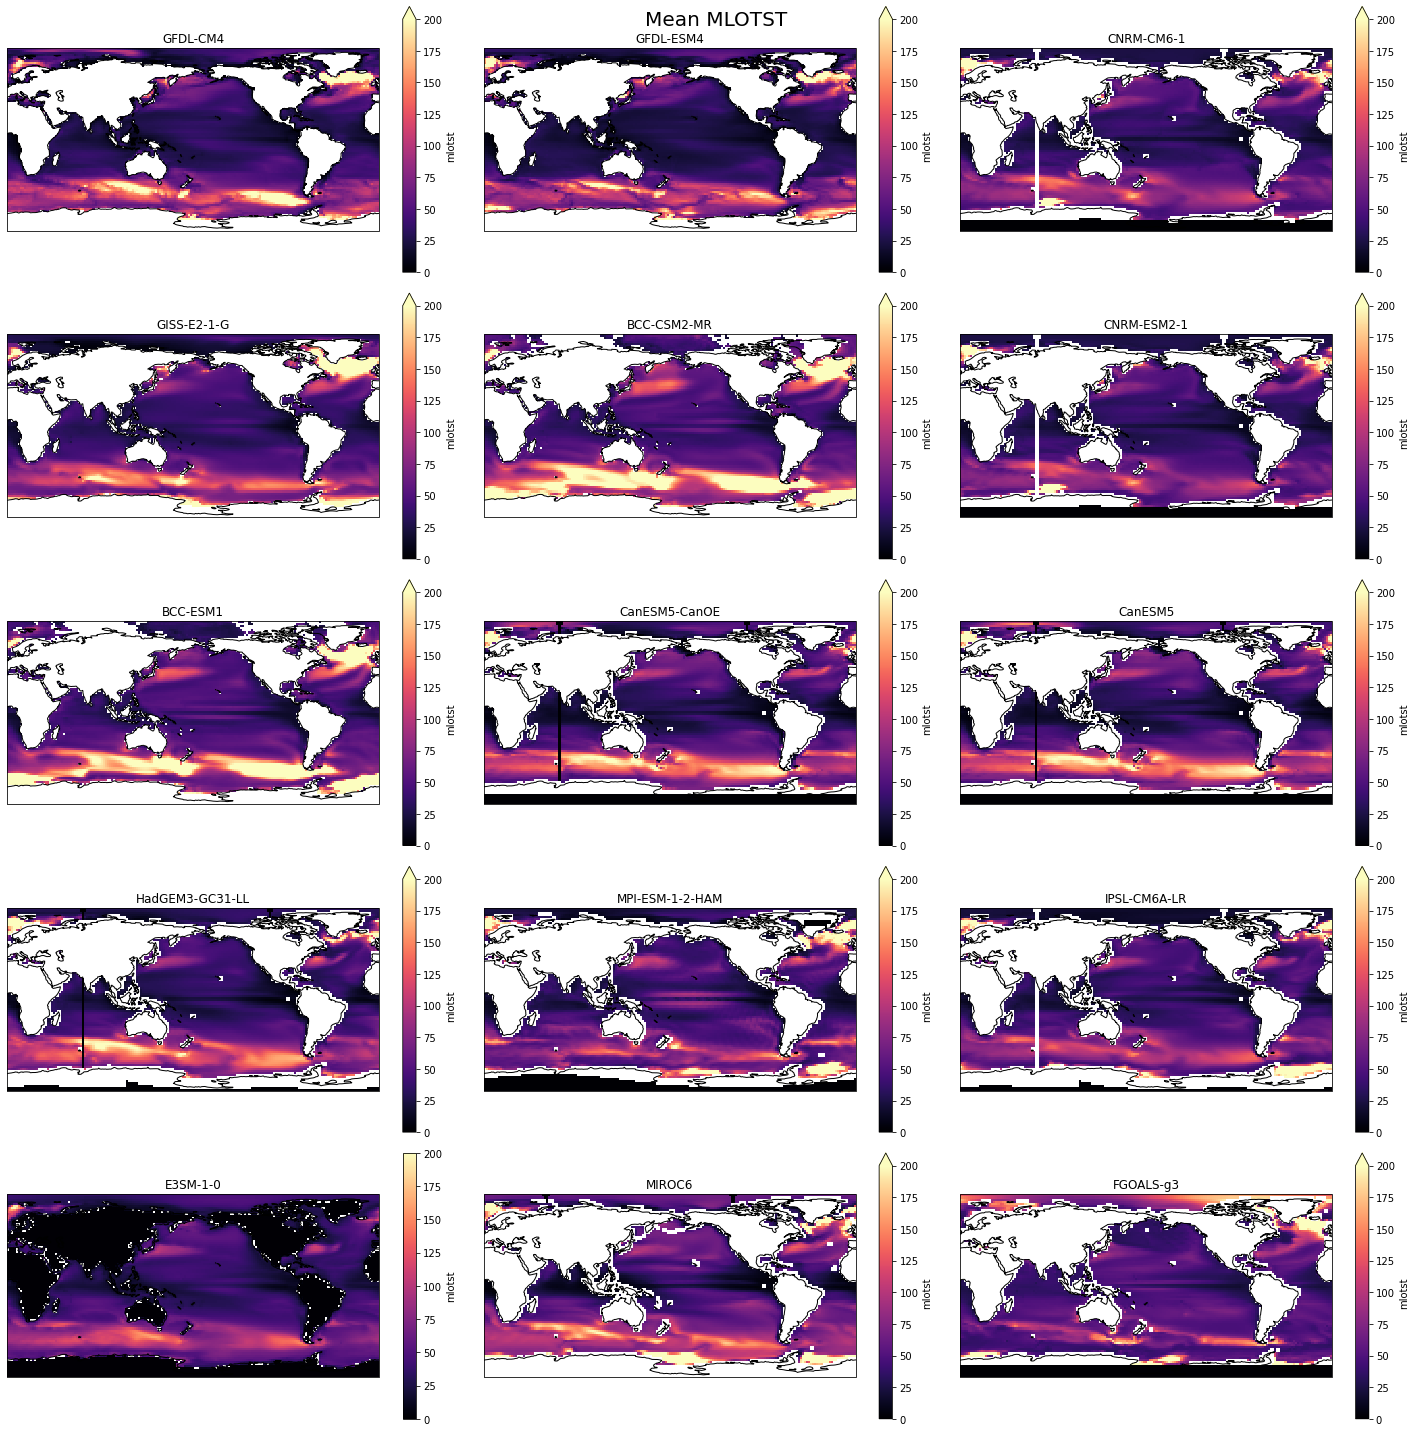

In [117]:
fig = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.1)

i = 1

for model in mlotst_control['name'].values:
    ax = fig.add_subplot(5,3,i, projection=ccrs.PlateCarree(central_longitude=180))
    mlotst_control.sel(name=model).mean('time').plot(ax=ax, transform=ccrs.PlateCarree(), vmin=0, vmax=200, cmap='magma')
    ax.coastlines(color='black', linewidth=1)
    plt.title(model)
    i += 1
plt.tight_layout()
plt.suptitle('Mean MLOTST', fontsize=20, y=0.99)

## 25 year mixed layer variability 

Text(0.5, 0.99, 'MLOTST 25 Year Variability')

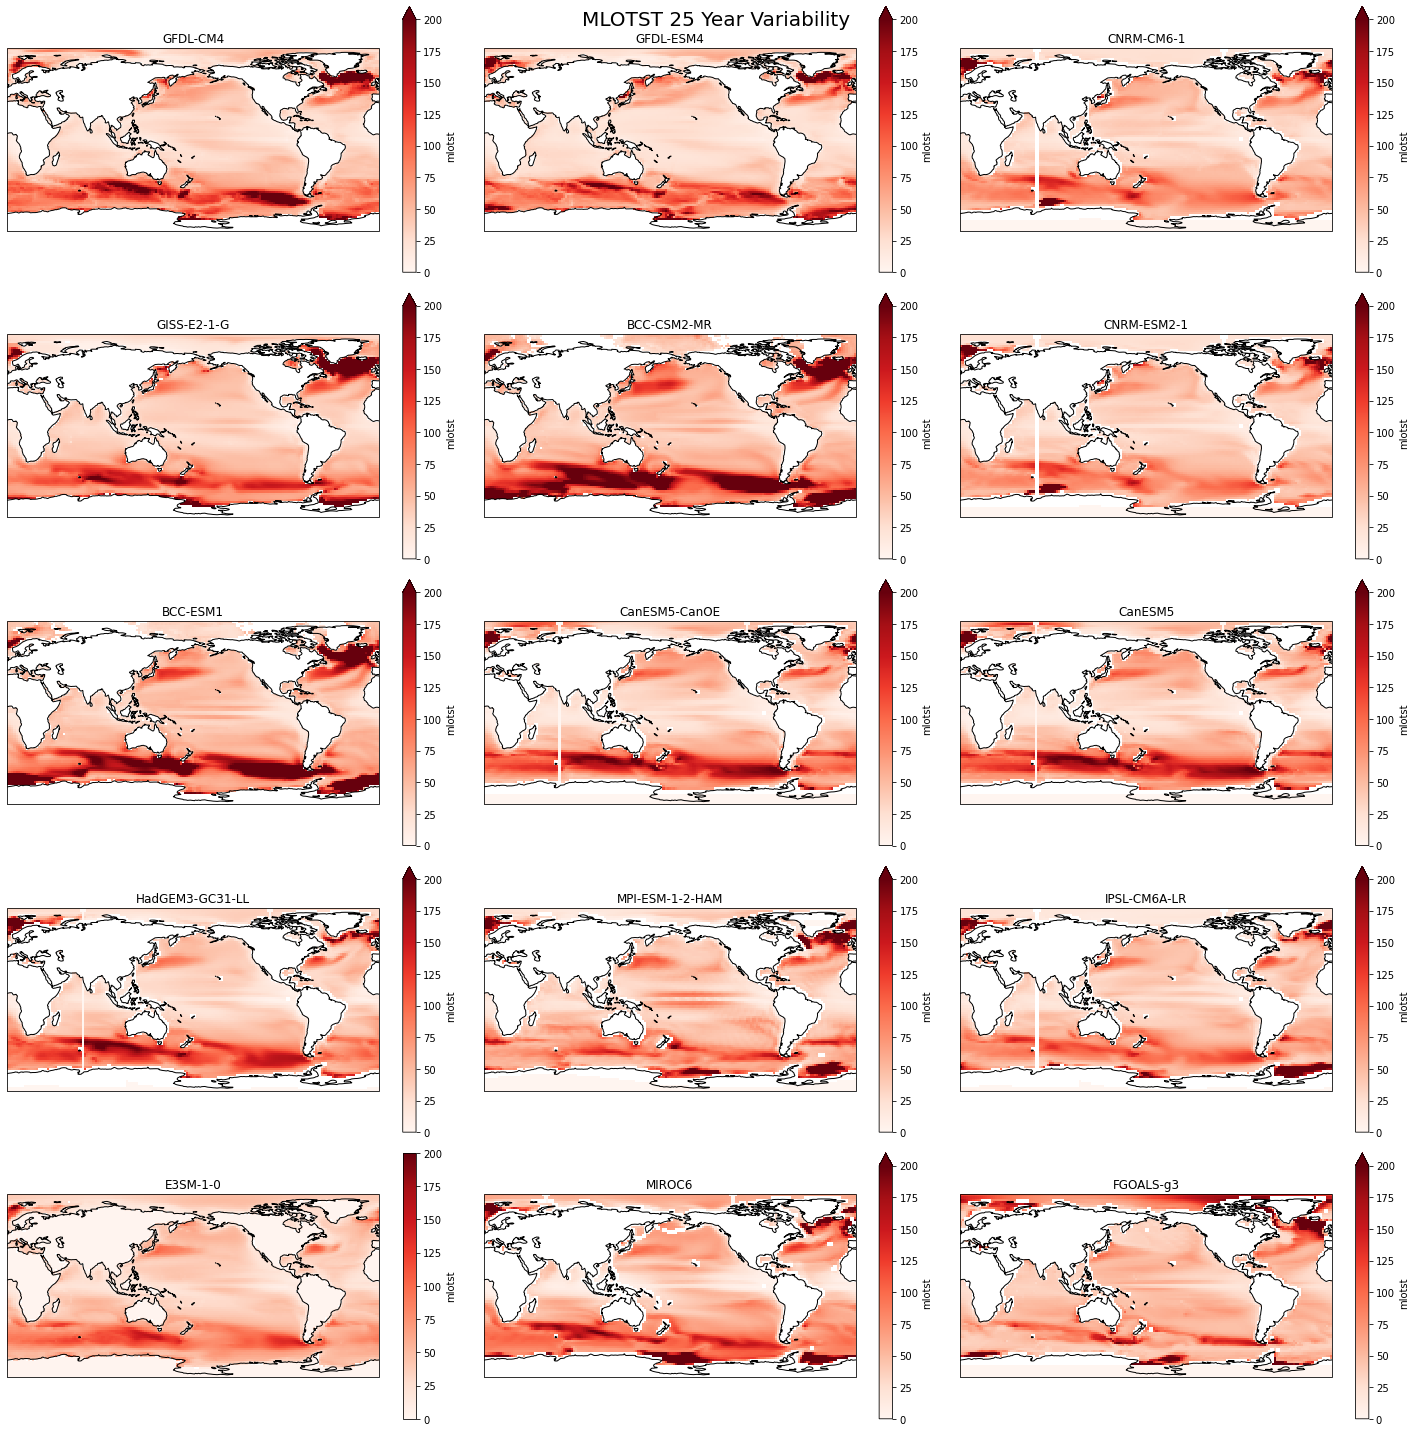

In [126]:
fig = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.1)

i = 1

for model in mlotst_control['name'].values:
    ax = fig.add_subplot(5,3,i, projection=ccrs.PlateCarree(central_longitude=180))
    rolling = mlotst_control.sel(name=model).rolling(time=300, center=True).mean('time')
    rolling.mean('time').plot(ax=ax, transform=ccrs.PlateCarree(), vmin=0, vmax=200, cmap='Reds')
    ax.coastlines(color='black', linewidth=1)
    plt.title(model)
    i += 1
plt.tight_layout()
plt.suptitle('MLOTST 25 Year Variability', fontsize=20, y=0.99)

## Ensemble mean 25 year variability

In [133]:
MLOTST_rolling = mlotst_control.rolling(time=300, center=True).mean('time')
MLOTST_stand = MLOTST_rolling.std('time')
MLOTST_var = MLOTST_stand.mean('name')

Text(0.5, 1.0, '25 year MLOTST interdecadal variability (N=15)')

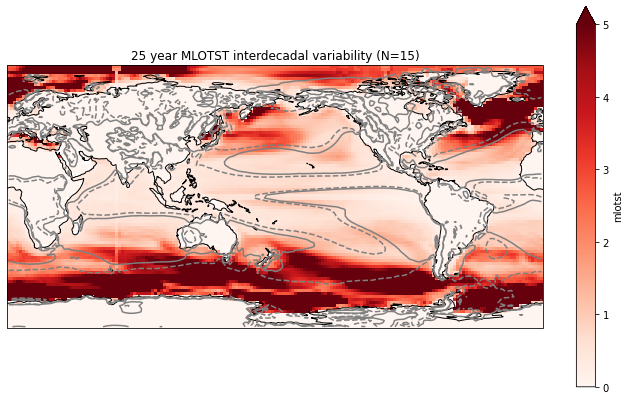

In [141]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
MLOTST_var.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=0, vmax=5, cmap='Reds')
ax.coastlines(color='black', linewidth=1)
vert_ds.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title('25 year MLOTST interdecadal variability (N=15)')

In [132]:
mlotst_control.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/250yeardatasets/CMIP_mlotst_piControl_250yr.nc')

In [4]:
mlotst_oldmethod = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/CMIP_mlotst_piControl_2x2_15memens.nc')
mlotst_oldmethod.load()

<xarray.DataArray (name: 15, time: 1500, lat: 88, lon: 179)>
array([[[[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [50.41090584, 52.04710674, 50.50968361, ..., 48.75899982,
          49.236413  , 46.89223766],
         [31.22230101, 32.50833845, 32.35529757, ..., 40.54614592,
          40.76375866, 39.32892752],
         [53.78388977, 52.79047012, 53.00532818, ..., 47.45863438,
          47.6057272 , 50.86550903]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
...
         [22.22373772, 19.68608475, 17.70999527, ..., 32.2755928 ,
          30.69525719, 27.84095955],
         [25.45349121, 25.06351852, 24.72636795, ..., 25.39812469,
          25.5584774 , 25.59752464],
         [24.32390594, 24.3410244 , 24.33765221, ..., 23.76138496,
          24.04454803, 24.23335075]],

        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [31.01957703, 27.70540428, 25.07566071, ..., 39.35926056,
          38.68805313, 36.53044891],
         [35.33967209, 34.22472763, 33.02606201, ..., 34.47336197,
          35.42287064, 35.58819199],
         [32.27497101, 32.29590225, 32.31086731, ..., 31.77479553,
          32.05541229, 32.22546387]]]])
Coordinates:
    latitude   (lat, lon) float32 nan nan nan nan nan ... 86.99 86.92 86.8 86.61
    longitude  (lat, lon) float32 nan nan nan nan ... -5.602 2.988 11.02 18.28
  * time       (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * lat        (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon        (lon) int64 1 3 5 7 9 11 13 15 ... 345 347 349 351 353 355 357
  * name       (name) object 'GFDL-CM4' 'GFDL-ESM4' ... 'HadGEM3-GC31-LL'
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    interp_method:  conserve_order1
    long_name:      Ocean Mixed Layer Thickness Defined by Sigma T
    original_name:  mlotst
    standard_name:  ocean_mixed_layer_thickness_defined_by_sigma_t
    units:          m

## Processing with the old method

Text(0.5, 0.99, 'Mean MLOTST - old method')

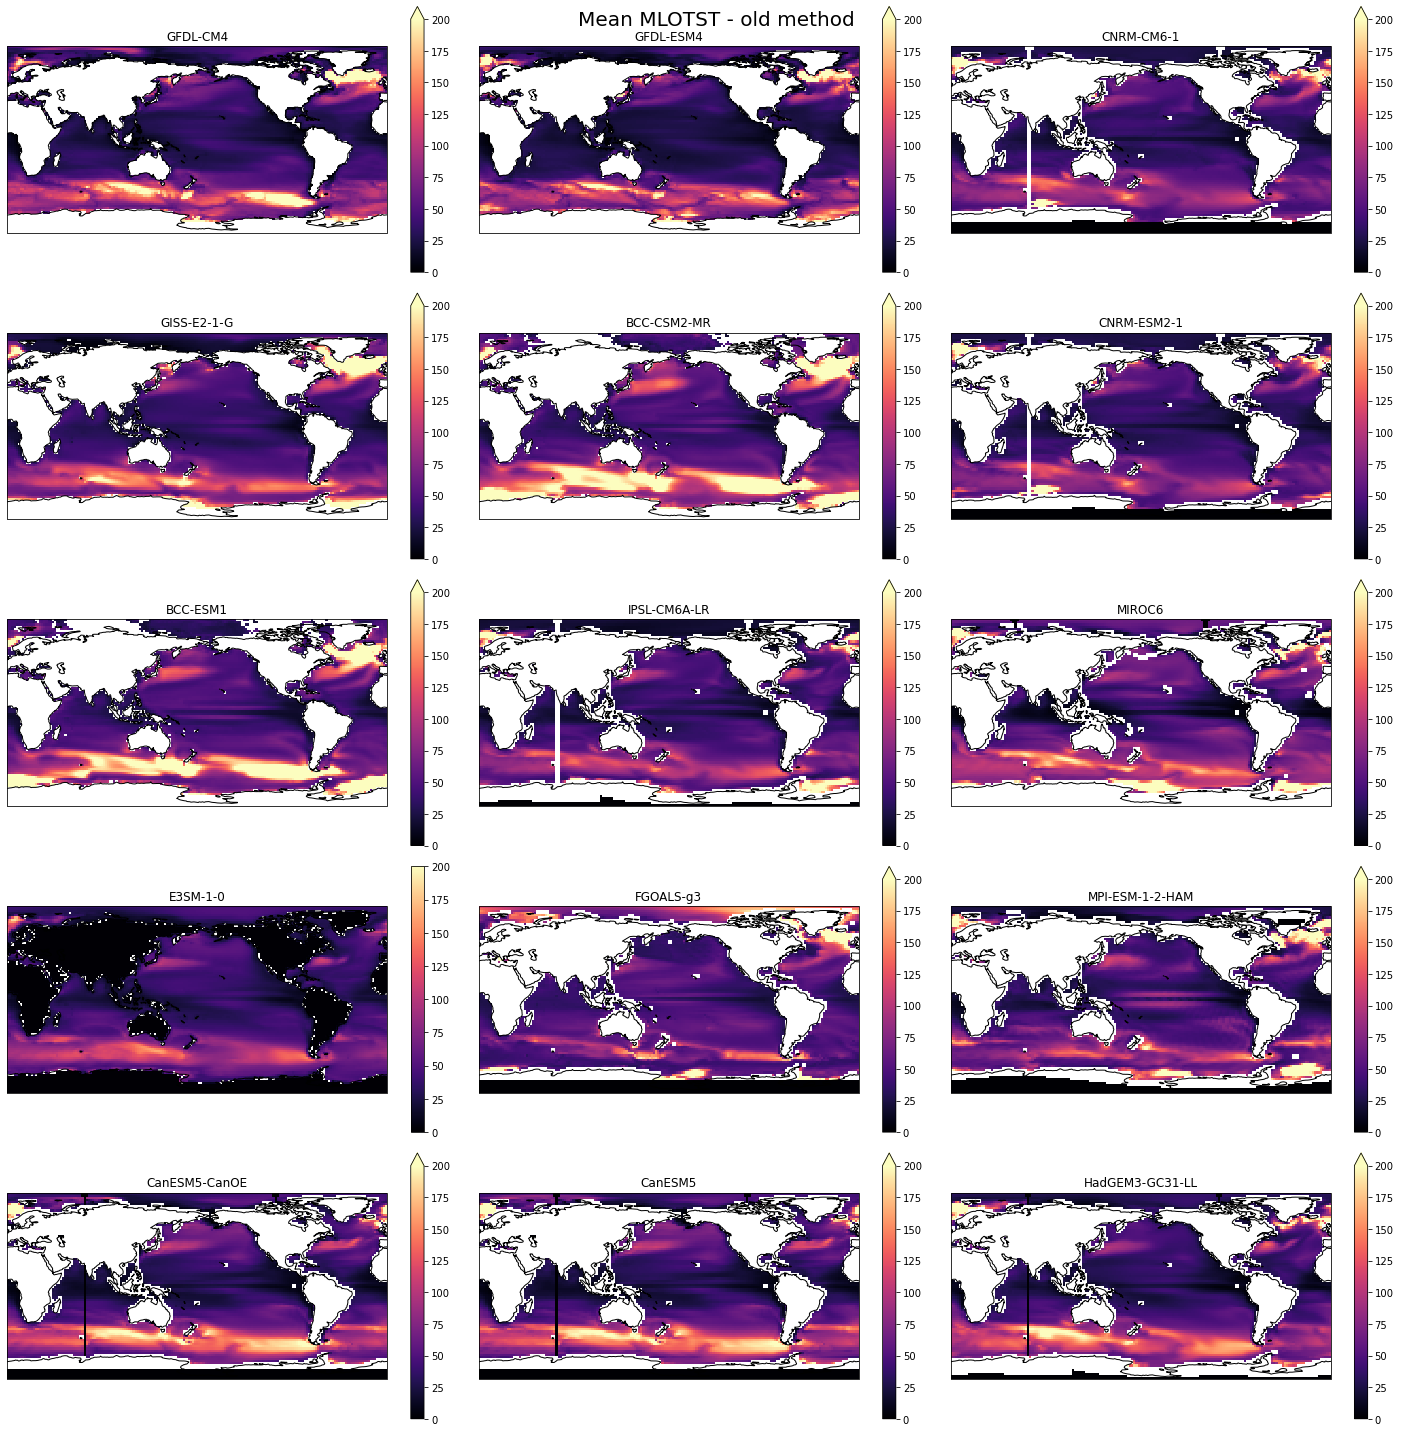

In [130]:
fig = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.1)

i = 1

for model in mlotst_oldmethod['name'].values:
    ax = fig.add_subplot(5,3,i, projection=ccrs.PlateCarree(central_longitude=180))
    mlotst_oldmethod.sel(name=model).mean('time').plot(ax=ax, transform=ccrs.PlateCarree(), vmin=0, vmax=200, cmap='magma')
    ax.coastlines(color='black', linewidth=1)
    plt.title(model)
    i += 1
plt.tight_layout()
plt.suptitle('Mean MLOTST - old method', fontsize=20, y=0.99)

Text(0.5, 0.99, 'MLOTST 25 Year Variability - Old Method')

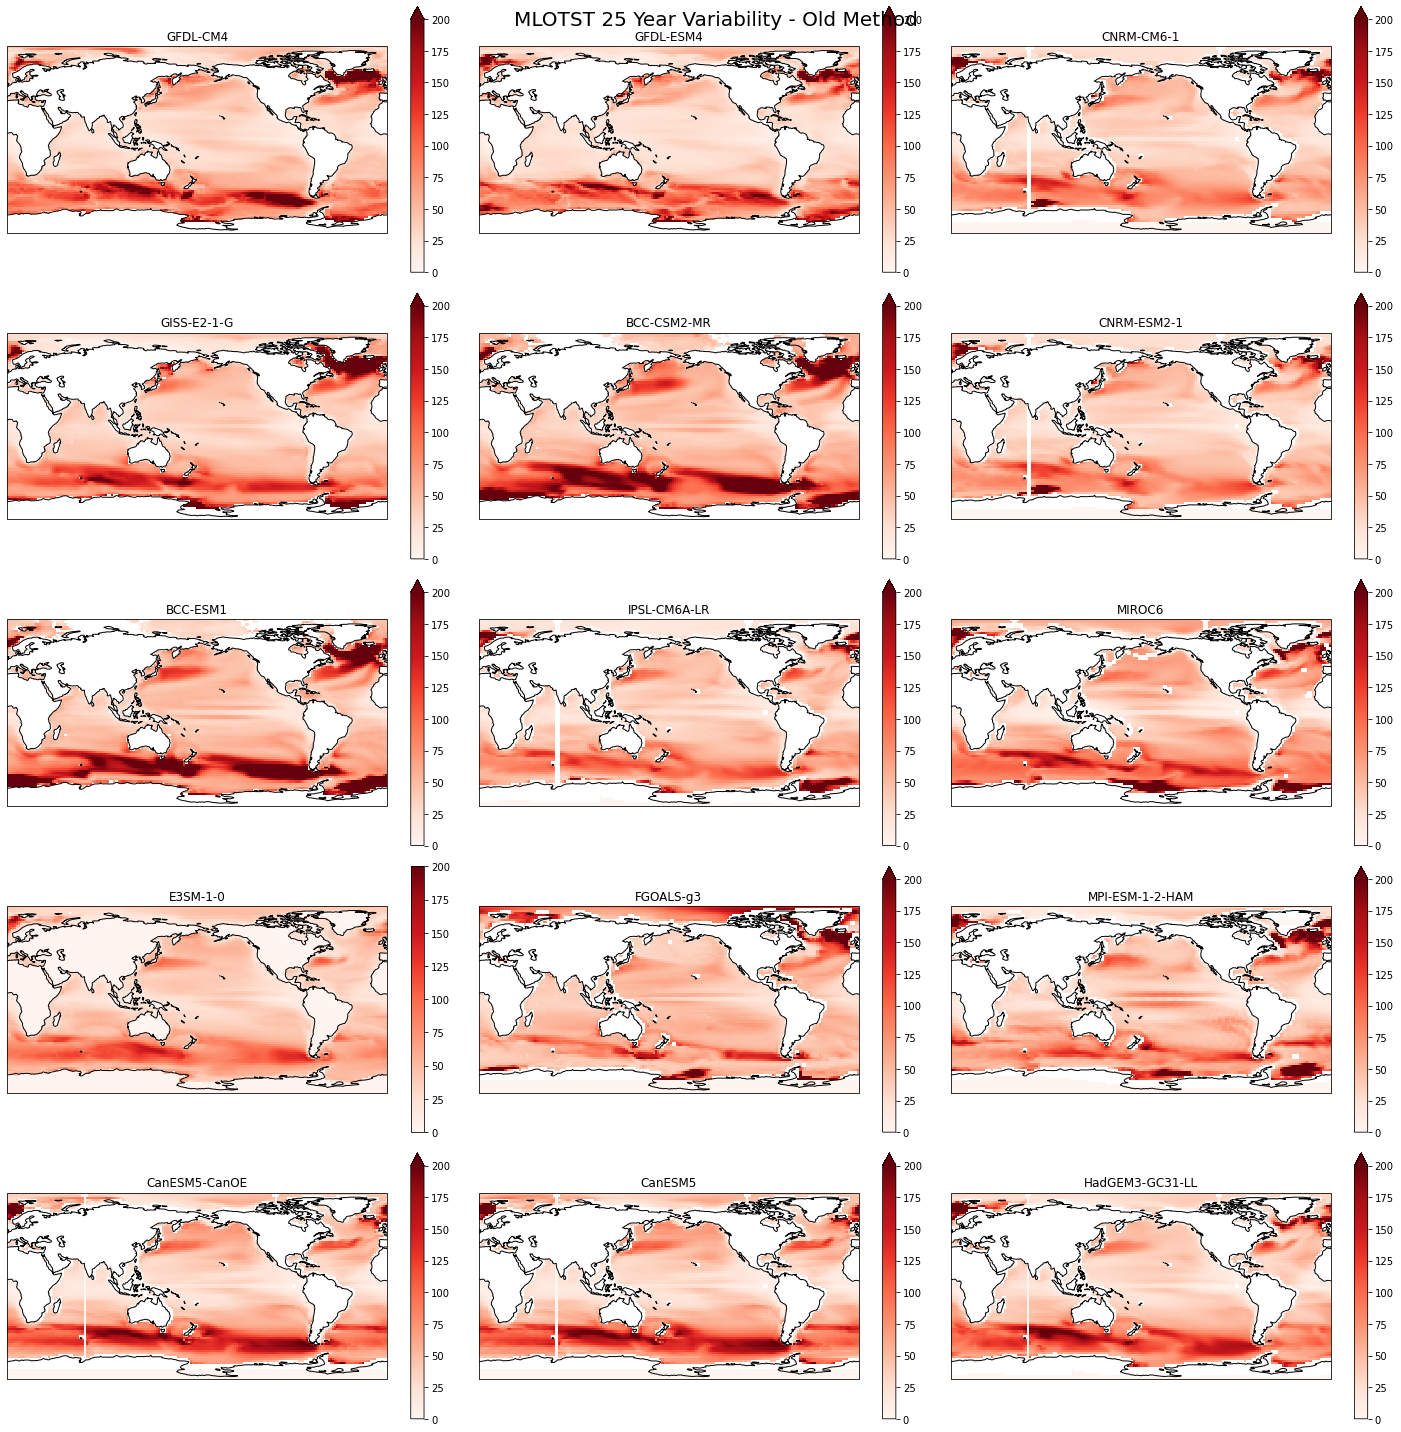

In [5]:
fig = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.1)

i = 1

for model in mlotst_oldmethod['name'].values:
    ax = fig.add_subplot(5,3,i, projection=ccrs.PlateCarree(central_longitude=180))
    rolling = mlotst_oldmethod.sel(name=model).rolling(time=300, center=True).mean('time')
    rolling.mean('time').plot(ax=ax, transform=ccrs.PlateCarree(), vmin=0, vmax=200, cmap='Reds')
    ax.coastlines(color='black', linewidth=1)
    plt.title(model)
    i += 1
plt.tight_layout()
plt.suptitle('MLOTST 25 Year Variability - Old Method', fontsize=20, y=0.99)

# Testing

In [6]:
df_hml_HadGEM3 = df.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'mlotst' & experiment_id == 'piControl' & source_id == 'HadGEM3-GC31-LL'").head(1)
df_hml_HadGEM3

activity_id institution_id        source_id experiment_id member_id  \
523689        CMIP           MOHC  HadGEM3-GC31-LL     piControl  r1i1p1f1   

       table_id variable_id grid_label  \
523689     Omon      mlotst         gn   

                                                   zstore  dcpp_init_year  \
523689  gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/piC...             NaN   

         version  
523689  20211103

In [45]:
mlotst_HadGEM3 = mlotst_load_ufunc(df_hml_HadGEM3)

HadGEM3-GC31-LL
<xarray.DataArray 'mlotst' (time: 3000, y: 330, x: 360)>
dask.array<getitem, shape=(3000, 330, 360), dtype=float32, chunksize=(225, 330, 360), chunktype=numpy.ndarray>
Coordinates:
    lat      (y, x) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 2100-12-31
Dimensions without coordinates: y, x
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        Sigma T is potential density referenced to ocean surface.
    long_name:      Ocean Mixed Layer Thickness Defined by Sigma T
    original_name:  mo: (variable_name: mlotst)
    standard_name:  ocean_mixed_layer_thickness_defined_by_sigma_t
    units:          m
(180,)
<xarray.DataArray (time: 3000, y: 90, x: 180)>
dask.array<_regrid, shape=(3000, 90, 180), dtype=float32, chunksize=(225, 90, 180), chunktype=numpy.nd

/tmp/ipykernel_117067/1620798843.py:63: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  zout = xr.apply_ufunc(interp_griddata, xin, yin, zin, xm, ym,


HadGEM3-GC31-LL processed
<xarray.DataArray (time: 3000, lat: 88, lon: 179)>
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [30.71750832, 29.64086151, 28.25364876, ..., 37.24291229,
         35.04535294, 33.25634766],
        [31.68507385, 31.73269653, 31.76385498, ..., 31.45937347,
         31.4696579 , 31.54091835],
        [34.02612305, 34.09165192, 34.13754654, ..., 33.83340836,
         33.86871338, 33.91246033]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [        nan,         nan,         nan, ...,         nan,
                 nan,     

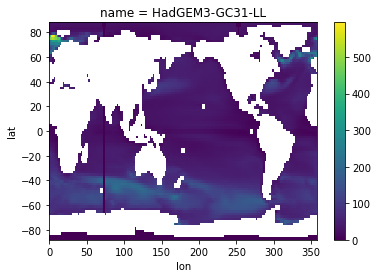

In [46]:
mlotst_HadGEM3.mean('time').plot()

In [9]:
df_hml_CanESM5 = df.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'mlotst' & experiment_id == 'piControl' & source_id == 'CanESM5'").head(1)
df_hml_CanESM5

activity_id institution_id source_id experiment_id member_id table_id  \
89859        CMIP          CCCma   CanESM5     piControl  r1i1p1f1     Omon   

      variable_id grid_label  \
89859      mlotst         gn   

                                                  zstore  dcpp_init_year  \
89859  gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/piControl/...             NaN   

        version  
89859  20190429

In [10]:
mlotst_CanESM5 = mlotst_load(df_hml_CanESM5)

CanESM5
0
1.8408477306365967
100
169.06309914588928
200
165.47023725509644


KeyboardInterrupt: 

In [12]:
df_hml_CanESM5_CanOE = df.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'mlotst' & experiment_id == 'piControl' & source_id == 'CanESM5-CanOE'").head(1)
df_hml_CanESM5_CanOE

activity_id institution_id      source_id experiment_id member_id  \
87841        CMIP          CCCma  CanESM5-CanOE     piControl  r1i1p2f1   

      table_id variable_id grid_label  \
87841     Omon      mlotst         gn   

                                                  zstore  dcpp_init_year  \
87841  gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/piCo...             NaN   

        version  
87841  20190429

In [18]:
mlotst_CanESM5CanOE = mlotst_load(df_hml_CanESM5_CanOE)

CanESM5-CanOE
0
1.3539164066314697
Fri Feb 16 12:34:00 2024
100
135.97357606887817
Fri Feb 16 12:36:16 2024
200
146.4726014137268
Fri Feb 16 12:38:43 2024
300
153.87383389472961
Fri Feb 16 12:41:17 2024
400
151.3892207145691
Fri Feb 16 12:43:48 2024
500
147.74276328086853
Fri Feb 16 12:46:16 2024
600
147.48832488059998
Fri Feb 16 12:48:43 2024
700
158.78360867500305
Fri Feb 16 12:51:22 2024
800
147.66990518569946
Fri Feb 16 12:53:50 2024
900
145.8843138217926
Fri Feb 16 12:56:16 2024
1000
146.54380702972412
Fri Feb 16 12:58:42 2024


KeyboardInterrupt: 

In [60]:
df_hml_MPIESM = df.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'mlotst' & experiment_id == 'piControl' & source_id == 'MPI-ESM-1-2-HAM'").head(1)
df_hml_MPIESM

activity_id     institution_id        source_id experiment_id  \
407439        CMIP  HAMMOZ-Consortium  MPI-ESM-1-2-HAM     piControl   

       member_id table_id variable_id grid_label  \
407439  r1i1p1f1     Omon      mlotst         gn   

                                                   zstore  dcpp_init_year  \
407439  gs://cmip6/CMIP6/CMIP/HAMMOZ-Consortium/MPI-ES...             NaN   

         version  
407439  20200120

In [20]:
mlotst_MPIESM = mlotst_load(df_hml_MPIESM)

MPI-ESM-1-2-HAM


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dty

0
1.48968505859375
Fri Feb 16 13:15:04 2024
100
145.281729221344
Fri Feb 16 13:17:29 2024
200
151.55665683746338
Fri Feb 16 13:20:01 2024
300
153.78099012374878
Fri Feb 16 13:22:35 2024
400
149.3816635608673
Fri Feb 16 13:25:04 2024
500
151.96815037727356
Fri Feb 16 13:27:36 2024
600
151.66523432731628
Fri Feb 16 13:30:08 2024
700
152.73396253585815
Fri Feb 16 13:32:41 2024
800
154.56658029556274
Fri Feb 16 13:35:15 2024
900
160.41902995109558
Fri Feb 16 13:37:56 2024
1000
165.4810254573822
Fri Feb 16 13:40:41 2024
1100
167.54537868499756
Fri Feb 16 13:43:29 2024
1200
167.93363523483276
Fri Feb 16 13:46:16 2024
1300
167.2089729309082
Fri Feb 16 13:49:04 2024
1400
177.04118871688843
Fri Feb 16 13:52:01 2024
1500
166.35709857940674
Fri Feb 16 13:54:47 2024
1600
182.34733533859253
Fri Feb 16 13:57:49 2024
1700
176.78548955917358
Fri Feb 16 14:00:46 2024
1800
179.36463236808777
Fri Feb 16 14:03:46 2024
1900
186.1148407459259
Fri Feb 16 14:06:52 2024
2000
181.06188893318176
Fri Feb 16 14:09

In [21]:
mlotst_MPIESM.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/250yeardatasets/CMIP_mlotst_MPIESM_250yr.nc')

In [48]:
mlotst_MPIESM = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/250yeardatasets/CMIP_mlotst_MPIESM_250yr.nc')

In [80]:
mlotst_MPIESM

<xarray.DataArray (time: 3000, lat: 88, lon: 179)>
array([[[ 0.      ,  0.      , ...,  0.      ,  0.      ],
        [ 0.      ,  0.      , ...,  0.      ,  0.      ],
        ...,
        [36.013218, 34.477581, ..., 37.645443, 37.382648],
        [24.926708, 24.507002, ..., 28.289654, 27.019087]],

       [[ 0.      ,  0.      , ...,  0.      ,  0.      ],
        [ 0.      ,  0.      , ...,  0.      ,  0.      ],
        ...,
        [27.184408, 24.428133, ..., 36.809616, 33.959213],
        [18.690365, 18.150745, ..., 23.218657, 21.220398]],

       ...,

       [[ 0.      ,  0.      , ...,  0.      ,  0.      ],
        [ 0.      ,  0.      , ...,  0.      ,  0.      ],
        ...,
        [23.610302, 23.442722, ..., 24.978991, 24.594625],
        [23.521713, 22.903257, ..., 25.801722, 24.933979]],

       [[ 0.      ,  0.      , ...,  0.      ,  0.      ],
        [ 0.      ,  0.      , ...,  0.      ,  0.      ],
        ...,
        [27.584404, 25.295013, ..., 31.801029, 30.328749],
        [28.869772, 28.331699, ..., 32.491619, 30.837677]]])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 2100-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
    name     object ...

Text(0.5, 1.0, 'MLOTST - MPI-ESM-1-2-HAM')

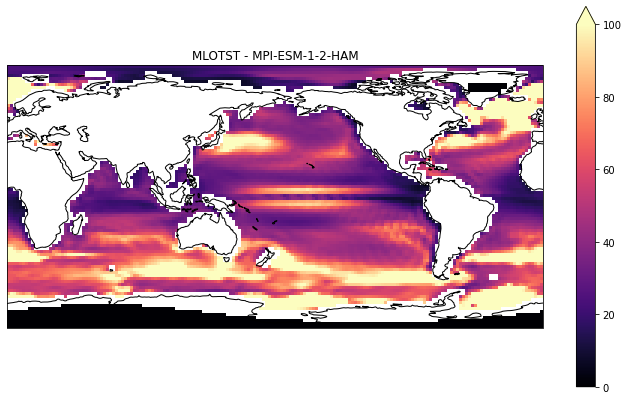

In [59]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
mlotst_MPIESM.mean('time').plot(ax=ax, transform=ccrs.PlateCarree(), vmin=0, vmax=100, cmap='magma')
ax.coastlines(color='black', linewidth=1)
plt.title('MLOTST - MPI-ESM-1-2-HAM')

Text(0.5, 1.0, 'MLOTST - MPI-ESM-1-2-HAM - parallelized')

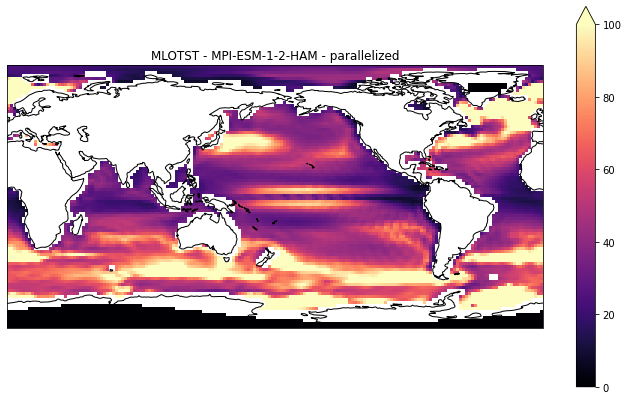

In [63]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
mlotst_MPIESM_optim.mean('time').plot(ax=ax, transform=ccrs.PlateCarree(), vmin=0, vmax=100, cmap='magma')
ax.coastlines(color='black', linewidth=1)
plt.title('MLOTST - MPI-ESM-1-2-HAM - parallelized')

In [61]:
mlotst_MPIESM_optim = mlotst_load_ufunc(df_hml_MPIESM)

MPI-ESM-1-2-HAM


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dty

<xarray.DataArray 'mlotst' (time: 3000, y: 220, x: 256)>
dask.array<getitem, shape=(3000, 220, 256), dtype=float32, chunksize=(364, 220, 256), chunktype=numpy.ndarray>
Coordinates:
    lat      (y, x) float64 dask.array<chunksize=(220, 256), meta=np.ndarray>
    lon      (y, x) float64 dask.array<chunksize=(220, 256), meta=np.ndarray>
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 2100-12-31
Dimensions without coordinates: y, x
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        Sigma T is potential density referenced to ocean surface.
    history:        2019-12-07T13:16:06Z altered by CMOR: replaced missing va...
    long_name:      Ocean Mixed Layer Thickness Defined by Sigma T
    original_name:  mlotst
    standard_name:  ocean_mixed_layer_thickness_defined_by_sigma_t
    units:          m
(180,)
<xarray.DataArray (time: 3000, y: 90, x: 180)>
dask.array<_regrid, shape=(3000, 90, 180), dtype=float32, 

/tmp/ipykernel_117067/1620798843.py:63: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  zout = xr.apply_ufunc(interp_griddata, xin, yin, zin, xm, ym,


MPI-ESM-1-2-HAM processed
<xarray.DataArray (time: 3000, lat: 88, lon: 179)>
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [39.63874435, 36.66211319, 34.92984772, ..., 40.33957291,
         37.88332748, 37.25049973],
        [36.01321793, 34.47758102, 32.61141205, ..., 34.647686  ,
         37.64544296, 37.38264847],
        [24.92670822, 24.50700188, 24.4896946 , ..., 28.82389641,
         28.28965378, 27.01908684]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0. 

In [78]:
test_mpiesm = (mlotst_MPIESM == mlotst_MPIESM_optim).astype(int)
print(test_mpiesm)

<xarray.DataArray (time: 3000, lat: 88, lon: 179)>
array([[[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
...
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1,

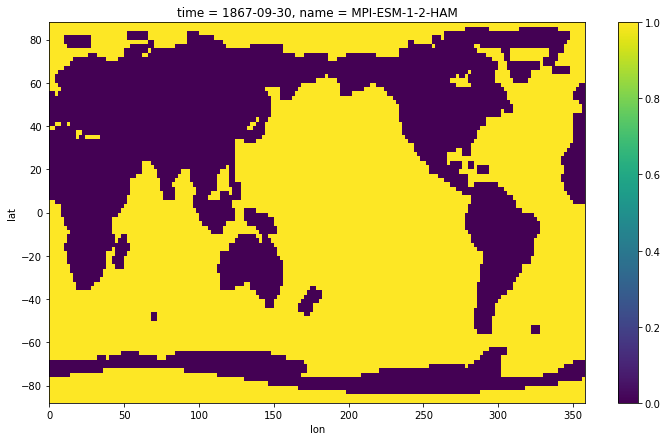

In [81]:
test_mpiesm.isel(time=200).plot()

In [75]:
np.where(test_mpiesm==True)

(array([   0,    0,    0, ..., 2999, 2999, 2999]),
 array([ 0,  0,  0, ..., 87, 87, 87]),
 array([  0,   1,   2, ..., 176, 177, 178]))

In [76]:
np.where(test_mpiesm==False)

(array([   0,    0,    0, ..., 2999, 2999, 2999]),
 array([ 2,  2,  2, ..., 86, 86, 86]),
 array([ 99, 100, 101, ..., 167, 168, 169]))